# Measurement types
In this notebook we
- compare the different ways of taking measurements (point-wise, different convolution types)
- make sure the gradients work in each case

**TODO:** integrate "flight" notation (instead of passing alpha)

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from FOM_stationary import FOM_stationary as FOM
from OEDUtility import OEDUtility
from Drone import Drone as Drone

from DetectorPointwise import DetectorPointwise
from DetectorUniform import DetectorUniform
from DetectorGaussian import DetectorGaussian
from DetectorTruncGaussian import DetectorTruncGaussian

from DetectorApprox import DetectorPointwise as _DetectorPointwise
from DetectorApprox import DetectorUniform as _DetectorUniform
from DetectorApprox import DetectorGaussian as _DetectorGaussian
from DetectorApprox import DetectorTruncGaussian as _DetectorTruncGaussian

from NavigationCircle import NavigationCircle as Navigation

import time
tStart_notebook = time.time()

## User settings

In [2]:
centers = [[0.35, 0.7], [0.8, 0.2], [0.7, 0.5], [0.1, 0.9]]
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_test = 40  # resolution for 1D plots
n_test_2d = 60  # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

sigma = 0.05  # std deviation for gaussian-type measurements. Get pointwise data for sigma -> 0
radius = 0.05  # truncation radius for truncation-style measurements

meshDim = 50  # discretization parameter (1D) for FOM
meshDim_drone = 10  # discretization parameter (1D) for subdomain in truncation-type measurements

## Setup

Setup the full-order model. We've imported `FOM_stationary` class as `FOM`.

In [3]:
tStart = time.time()
fom = FOM(meshDim = meshDim, centers=centers)
print("Runtime of this block: {} s".format(time.time()-tStart))
n_para = fom.n_para

# compute one solution for nicer visualization below
para_true = np.ones((n_para,))
state = fom.solve(parameter=para_true)

Runtime of this block: 4.850174188613892 s


Set the prior, just as in the previous notebook:

In [4]:
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

As `Navigation` class we have again imported `NavigationCircle` in order to have a simple flight parameterization for easy-to-understand plots.

In [5]:
navigation = Navigation()

## Drones

### types of measurements

#### point-wise measurements
The simplest measurement type, we've already seen it in the previous notebook:

$$d(s) = u(x=p(t), s=s)$$

where
- $p$ is the flightpath
- $s$ the time at which we evaluate the measurement

In [6]:
detector_pointwise = DetectorPointwise(fom)
drone_pointwise = Drone(detector=detector_pointwise, navigation=navigation)

_detector_pointwise = _DetectorPointwise(fom)
_drone_pointwise = Drone(detector=_detector_pointwise, navigation=navigation)

#### convolution-type: uniform
Another possibility for modelling the measurements is to choose a weighted characteristic function $\Phi(x,y) = \|\Omega_y\|^{-1} \mathbb{1}_{\Omega_y}(x)$ for a measureable domain $\Omega_y \subset \Omega$, $y \in \Omega_y$. In this case a measurement of the state $u$ at time $s$ around position $y$ has the form
$$\ell_y(u,s) := \int_{\Omega} u(x, s) \Phi(x,y) dx = \frac{1}{\|\Omega_y\|} \int_{\Omega_y} u(x, s) dx.$$ 
It is the mean value of a state $u$ over the subdomain $\Omega_y$. 

For our drones, we choose $y$ as the position the flight path $p$ reaches at time $s$, i.e. $y=p(s)$. We then get:
$$d(s) = \ell_{p(s)}(u,s)$$

For our example problem we have chosen 
$$\Omega_y = B_r(y) \cap \Omega,$$
i.e. a ball (actually circle since we are in 2D) around the point $y$ with radius $r$ intersected with the modelling domain $\Omega$. Of course, in discrete forms it's not quite a circle until we look at the limit $h\rightarrow 0$ of infinitely small mesh size, but for a sufficiently refined mesh it's good enough.

We can rewrite the above to get a form that is simpler to approximate:
$$ \ell_y(u, s) = \frac{\int_{B_r(y)} u(x, s) \mathbb{1}_{\Omega}(x) dx}{\int_{B_r(y)} \mathbb{1}_{\Omega}(x) dx }$$
where $u(x, s)$ is not defined outside of $\Omega$, but we can assign any finite value such that $u(x, s) \mathbb{1}_{\Omega}(x) = 0 \quad \forall x \notin \Omega$.

To evaluate the approximation, we assign $u(x, s) = 0 \quad \forall x \notin \Omega$, and replace integrals $\int_{B_r} (\cdot) dx$ by a convolution with a ball kernel: $u \star \Phi$ and $\mathbb{1}_\Omega \star \Phi$ where $\Phi$ is a ball kernel, i.e., $\Phi(x) = \mathbb{1}_{B_r}$.

The value at $y$ is then
$$ \ell_y(u, s) = \frac{(u \star \Phi)(y, s)}{(\mathbb{1}_\Omega \star \Phi)(y, s)}$$
Computing the convolutions using a discretized measurement of $u$ is fast and a bivariate spline can be easily fit to the discretized data and differentiated trivially.

In [7]:
detector_uniform = DetectorUniform(fom, radius=radius, meshDim=meshDim_drone)
drone_uniform = Drone(detector=detector_uniform, navigation=navigation)

_detector_uniform = _DetectorUniform(fom, radius=radius, meshDim=meshDim_drone)
_drone_uniform = Drone(detector=_detector_uniform, navigation=navigation)

#### convolution-type: truncated gaussian
The drone flies over the point $y = p(s)$ but then takes a measurement at a random location $x$ with $\|x-y\| \le \sigma$, i.e. a close point but not exactly $y$. The distribution for which $x$ is chosen is described by a truncated Gaussian. We can model this measurement statistically as the expectation of the state under this distribution.

\begin{align}
\Phi(x, y) = \left\{
\begin{array}{ll}
0 & \text{if } \|x-y\| \ge 2\sigma \\
C\exp(-\frac{1}{2\sigma^2} \|x-y\|^2) & \text{otherwise}
\end{array}
\right.
\end{align}
where $C$ is chosen such that $\int_{\Omega} \Phi(x, y) dx = 1$ for all $y$. We need the re-scaling such that $\Phi(\cdot, y)$ is indeed a probability densition function.

We define the measurement centered around a point $y \in \Omega$ of a state $u \in H^1(\Omega)$ as 
$$\ell_y(u, s) := \int_{\Omega} u(x, s) \Phi(x, y) dx 
= \int_{\|x-y\| \le 2\sigma} u(x, s) \Phi(x, y) dx 
= \mathbb{E}_{\pi_y}[u(\cdot, s)]
\in \mathbb{R}$$ 
where $\pi_y$ is the probability measure for the probability density function $\Phi(\cdot, y)$.

For our drone measurements we then get:
$$d(s) = \ell_{p(s)}(u, s)$$

We can write this again using the same form as above:
$$ \ell_y(u, s) = \frac{(u \star \Phi)(y, s)}{(\mathbb{1}_\Omega \star \Phi)(y, s)} $$
and again approximate the convolutions on a fixed grid numerically.

In [8]:
detector_truncated = DetectorTruncGaussian(fom, radius=radius, sigma=sigma, meshDim=meshDim_drone)
drone_truncated = Drone(detector=detector_truncated, navigation=navigation)

_detector_truncated = _DetectorTruncGaussian(fom, radius=radius, sigma=sigma, meshDim=meshDim_drone)
_drone_truncated = Drone(detector=_detector_truncated, navigation=navigation)

#### convolution-type: gaussian
In the case that the kernel function is a normal distribution with variance $\sigma$,
$$
\begin{align}
\Phi(x, y) = \frac{1}{\sigma \sqrt{2 \pi}}\exp\left(-\frac{1}{2\sigma^2} \|x-y\|^2\right)
\end{align}
$$

Applying this as a convolution is equivalent to a Weierstrass transform, which is equivalent to solving the heat equation for a fixed time interval. Solving the heat equation is simple using the FEM solver, but it is not immediately clear how to specify the boundary conditions for the heat equation solve.

As before, the same convolution form is equivalent:
$$ \ell_y(u, s) = \frac{(u \star \Phi)(y, s)}{(\mathbb{1}_\Omega \star \Phi)(y, s)}$$
and the convolutions approximated numerically. In this case, there are efficient algorithms that apply multiple one dimensional Gaussian convolutions to create the mutli-dimentional Gaussian here.

Note that we can write the convolutional form for any $\Phi(x, y)$ that can be written as $\Phi(x, y) = f(y - x)$ (the kernel has stationarity or is translation invariant). In the case of a pointwise measurement, $\Phi$ is a delta function.

In [9]:
tStart = time.time()
detector_gaussian = DetectorGaussian(fom, sigma=sigma)
drone_gaussian = Drone(detector=detector_gaussian, navigation=navigation)

#drone_gaussian = DroneGaussianEval(fom, sigma=sigma)
print("Gaussian drone initialization time: ", time.time()-tStart, " s.")

_detector_gaussian = _DetectorGaussian(fom, sigma=sigma)
_drone_gaussian = Drone(detector=_detector_gaussian, navigation=navigation)

Gaussian drone initialization time:  0.0003352165222167969  s.


**Note:** I haven't looked into which boundary conditions we need to set for the heat equation such that we indeed get the correct interpretation of the measurements with this class. Take any measurements with this function with a grain of salt.

## Comparison

The flight path will be the same for each drone, so we can just get it from one of them:

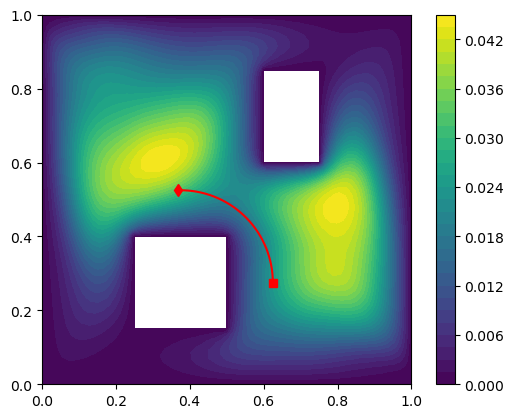

In [10]:
alpha = np.array([0.25, 0.1])
flight = drone_pointwise.plan_flight(alpha=alpha)
flightpath, grid_t = flight.flightpath, flight.grid_t

fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
plt.plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

In [11]:
data = np.zeros((3*2, grid_t.shape[0]))
measurement_time = np.zeros(3)
names = ["pointwise", "uniform", "trunc. Gaussian",]# "Gaussian, incorr. BC"]
names += ["approx_pointwise", "approx_uniform", "approx_trunc. Gaussian",]# "approx_Gaussian, incorr. BC"]

# pointwise
print("Starting: measurements with {} drone".format(names[0]))
tStart = time.time()
data[0,:] = drone_pointwise.measure(state=state, flight=flight)
measurement_time[0] = time.time()-tStart

# uniform
print("Starting: measurements with {} drone".format(names[1]))
tStart = time.time()
data[1,:] = drone_uniform.measure(state=state, flight=flight)
measurement_time[1] = time.time()-tStart

# # truncated gaussian
print("Starting: measurements with {} drone".format(names[2]))
tStart = time.time()
drone_truncated.is_test = True
data[2,:] = drone_truncated.measure(state=state, flight=flight)
measurement_time[2] = time.time()-tStart

# non-truncated Gaussian (Weierstrass trick)
# print("Starting: measurements with {} drone".format(names[3]))
# tStart = time.time()
# data[3,:] = drone_gaussian.measure(state=state, flight=flight)
# measurement_time[3] = time.time()-tStart

# pointwise
print("Starting: measurements with {} drone".format(names[0]))
tStart = time.time()
data[3,:] = _drone_pointwise.measure(state=state, flight=flight)
measurement_time[0] = time.time()-tStart

# uniform
print("Starting: measurements with {} drone".format(names[1]))
tStart = time.time()
data[4,:] = _drone_uniform.measure(state=state, flight=flight)
measurement_time[1] = time.time()-tStart

# # truncated gaussian
print("Starting: measurements with {} drone".format(names[2]))
tStart = time.time()
drone_truncated.is_test = True
data[5,:] = _drone_truncated.measure(state=state, flight=flight)
measurement_time[2] = time.time()-tStart

# # non-truncated Gaussian (Weierstrass trick)
# print("Starting: measurements with {} drone".format(names[3]))
# tStart = time.time()
# data[7,:] = _drone_gaussian.measure(state=state, flight=flight)
# measurement_time[3] = time.time()-tStart

print(measurement_time)

Starting: measurements with pointwise drone
Starting: measurements with uniform drone
Starting: measurements with trunc. Gaussian drone
Starting: measurements with pointwise drone
Starting: measurements with uniform drone
Starting: measurements with trunc. Gaussian drone
[0.14443016 0.14203024 0.13985372]


**Note:** I've commented out the measurements for `drone_gaussian` above because its code is no longer properly supported. Specifically:
1) the code for `drone_gaussian` is out of date and needs to be updated
2) we do not have the correct boundary conditions for `drone gaussian`, and computing them would be so expensive, it would defeat the purpose of this type of measurement. If anything we can make an approximation.
3) I'm not convinced globally weighted measurements make physical sense. At most this might make sense if the drone is fairly large compared to the domain, but then the model itself is likely way off. Unless for very specific scenarios, the boundary conditions should be imposed much further out than where we intend to measure.

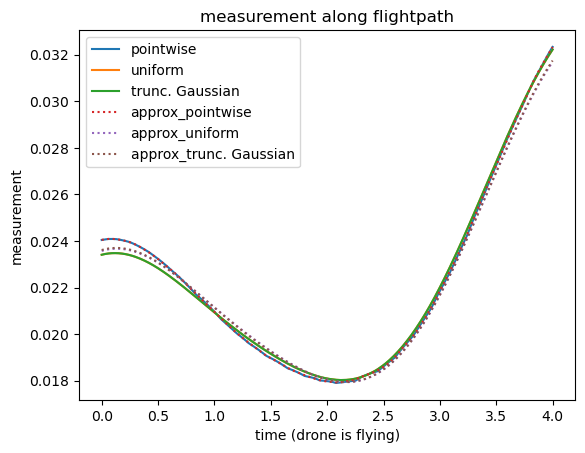

In [12]:
fig, ax = plt.subplots(1,1)

for i in range(3*2):
    if i < 3:
        style = '-'
    else:
        style = ':'
    ax.plot(grid_t, data[i, :], style, label = names[i])
    
ax.set_xlabel("time (drone is flying)")
ax.set_ylabel("measurement")
ax.set_title("measurement along flightpath")
ax.legend()

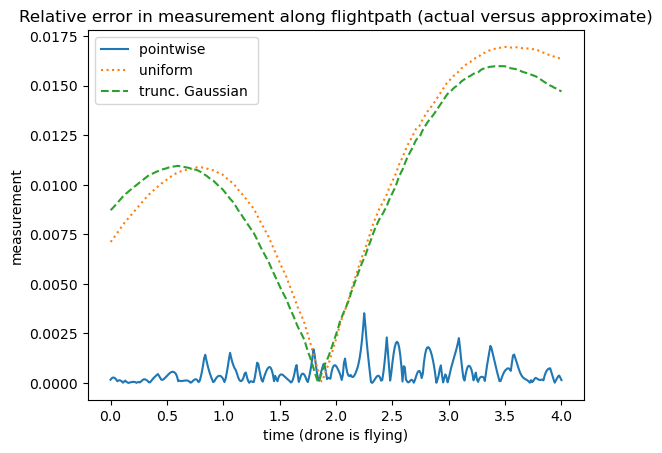

In [13]:
fig, ax = plt.subplots(1,1)

for i, ls in zip(range(3), ['-', ':', "--", "-"]):
    if names[i] != "Gaussian, incorr. BC":
        # ax.plot(grid_t, data[i, :] - data[i+3, :], ls, label = names[i])
        ax.plot(grid_t, np.abs(data[i, :] - data[i+3, :])/data[i, :], ls, label = names[i] + " ")
    
ax.set_xlabel("time (drone is flying)")
ax.set_ylabel("measurement")
ax.set_title("Relative error in measurement along flightpath (actual versus approximate)")
ax.legend()

## Derivatives

Because it's a lot of repeat code, I'm not going to paste it here individually for each drone. Instead, please define in the box below for which drone you'd like to visialize the OED utility functions and the derivatives. It takes about 2 min to switch out the drone, and a lot longer still to compute the 2D visualizations. If you don't have much time, make sure to set `bool_skip_2D_plots` to `True`

In [14]:
# user input
which_drone = _drone_truncated

bool_skip_2D_plots = True
# set to True to not compute 2D plots of measurements (can take quite a while to compute)

### inverse problem setup

In [15]:
# define inverse problem
inversion = InverseProblem(fom, which_drone)

# compute the states for the parameter basis
tStart = time.time()
inversion.compute_states(np.eye(n_para))
print("State solve time ({} parameters): {} s".format(n_para, time.time()-tStart))

# initialize object for computing the utility
utility = OEDUtility(inversion)

IOStream.flush timed out


State solve time (4 parameters): 283.73229146003723 s


In [16]:
# admissible domain
radius_min = la.norm(np.array([0.75, 0.55])/2 - np.array([0.5, 0.4])) # 0.1767
radius_max = la.norm(np.array([0, 0.55])/2) # 0.275
# drone may not collide with buildings or leave the domain

final_time = grid_t[-1]
speed_max = 2 * np.pi * radius_min / final_time
# maximum speed is chosen such that go for at most one circle

vec_speed = np.linspace(0.05 * speed_max, speed_max, n_test)
vec_radius = np.linspace(radius_min, radius_max, n_test+1)
# note: I'm not making the vectors the same lengths so I don't accidentally confuse the directions

### plot OED utility functions

In [17]:
if not bool_skip_2D_plots:

    tStart = time.time()

    # grid over admissible domain
    vec_speed_2d = np.linspace(0.05 * speed_max, speed_max, n_test_2d)
    vec_radius_2d = np.linspace(radius_min, radius_max, n_test_2d+1)

    # initialize
    util = np.zeros((3, n_test_2d+1, n_test_2d))

    for i in range(n_test_2d+1):
        for j in range(n_test_2d):

            alpha = np.array([vec_radius_2d[i], vec_speed_2d[j]])
            posterior = inversion.compute_posterior(alpha=alpha)

            util[0, i, j] = utility.eval_utility(posterior, mode="A")
            util[1, i, j] = utility.eval_utility(posterior, mode="D")
            util[2, i, j] = utility.eval_utility(posterior, mode="E")

    print("Runtime of this block: ", (time.time()-tStart)/60, "min.") # expect about 2 min for drone_gaussian

In [18]:
if not bool_skip_2D_plots:

    fig, axs = plt.subplots(1, 3, figsize=(15,5))

    for i in range(3):
        axs[i].pcolormesh(vec_speed_2d, vec_radius_2d, util[i, :, :])
        axs[i].set_xlabel("speed")
        axs[i].set_ylabel("radius")

    axs[0].set_title("A-OED")
    axs[1].set_title("D-OED")
    axs[2].set_title("E-OED")

### visualize derivatives

In [19]:
# user input: Where to evaluate the derivative:
speed_test = 0.21 # choose value between 0 and max(vec_speed) \approx 0.27768018
radius_test = 0.25 # choose value between radius_min \approx 0.1767766952966369 and radius_max \approx 0.275

tStart = time.time()

## IMPORTANT FOR THE OPTIMIZATION !!
alpha_test = np.array([radius_test, speed_test])
posterior_ref = inversion.compute_posterior(alpha=alpha_test)

util_ref = np.zeros(4)
print("Evaluating utility at reference")
util_ref[0] = utility.eval_utility(posterior_ref, mode="A")
util_ref[1] = utility.eval_utility(posterior_ref, mode="D")
util_ref[2] = utility.eval_utility(posterior_ref, mode="D-inverse")
util_ref[3] = utility.eval_utility(posterior_ref, mode="E")

print("Evaluating derivatives at reference")
tStart_sub = time.time()
der_ref_A = utility.d_utility_d_control(posterior_ref, mode="A")
der_ref_D = utility.d_utility_d_control(posterior_ref, mode="D")
der_ref_Dinv = utility.d_utility_d_control(posterior_ref, mode="D-inverse")
print("mean time for taking derivativies: ", (time.time()-tStart_sub)/3, " s.")
## done with the important part

print("Starting to compute 1D plot points")
util_test = np.zeros((4, 2, n_test+1))
for i in range(n_test+1):
    print("iteration {} / {}".format(i+1, n_test+1))
    
    if i < n_test:
        # vec_speed has one entry less (to avoid accidentally transposing the results)
        
        alpha = np.array([radius_test, vec_speed[i]])
        posterior = inversion.compute_posterior(alpha=alpha)

        util_test[0, 0, i] = utility.eval_utility(posterior, mode="A")
        util_test[1, 0, i] = utility.eval_utility(posterior, mode="D")
        util_test[2, 0, i] = utility.eval_utility(posterior, mode="D-inverse")
        util_test[3, 0, i] = utility.eval_utility(posterior, mode="E")
        
    alpha = np.array([vec_radius[i], speed_test])
    posterior = inversion.compute_posterior(alpha=alpha)

    util_test[0, 1, i] = utility.eval_utility(posterior, mode="A")
    util_test[1, 1, i] = utility.eval_utility(posterior, mode="D")
    util_test[2, 1, i] = utility.eval_utility(posterior, mode="D-inverse")
    util_test[3, 0, i] = utility.eval_utility(posterior, mode="E")
    
print("Runtime of this block: ", (time.time()-tStart)/60, "min.") # expect 0.2 min for gaussian drone

Evaluating utility at reference
Evaluating derivatives at reference
mean time for taking derivativies:  0.003399928410847982  s.
Starting to compute 1D plot points
iteration 1 / 41
iteration 2 / 41
iteration 3 / 41
iteration 4 / 41
iteration 5 / 41
iteration 6 / 41
iteration 7 / 41
iteration 8 / 41
iteration 9 / 41
iteration 10 / 41
iteration 11 / 41
iteration 12 / 41
iteration 13 / 41
iteration 14 / 41
iteration 15 / 41
iteration 16 / 41
iteration 17 / 41
iteration 18 / 41
iteration 19 / 41
iteration 20 / 41
iteration 21 / 41
iteration 22 / 41
iteration 23 / 41
iteration 24 / 41
iteration 25 / 41
iteration 26 / 41
iteration 27 / 41
iteration 28 / 41
iteration 29 / 41
iteration 30 / 41
iteration 31 / 41
iteration 32 / 41
iteration 33 / 41
iteration 34 / 41
iteration 35 / 41
iteration 36 / 41
iteration 37 / 41
iteration 38 / 41
iteration 39 / 41
iteration 40 / 41
iteration 41 / 41
Runtime of this block:  0.012887624899546306 min.


Text(0.5, 0, 'speed')

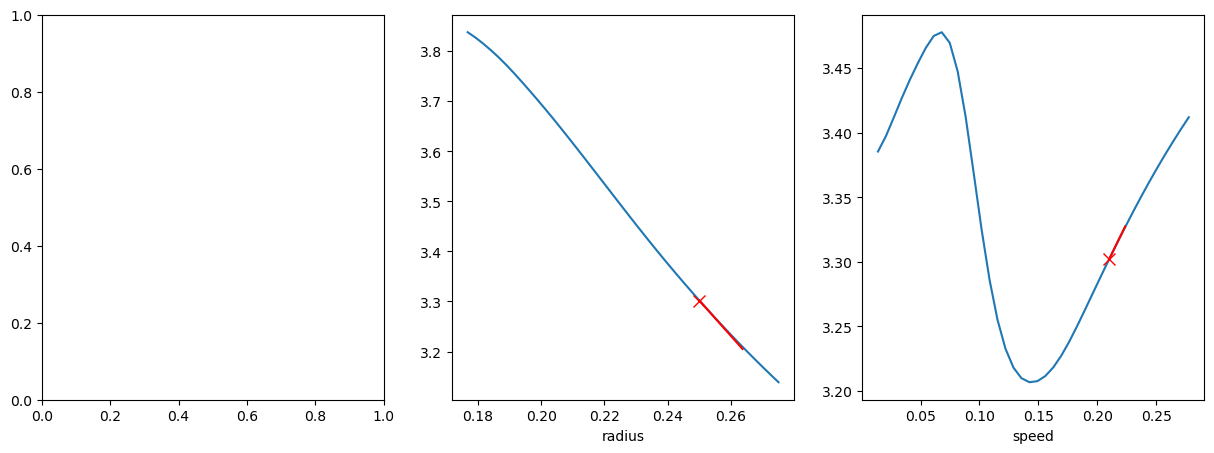

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
norm = la.norm(der_ref_A)
scale = 0.1/norm

if not bool_skip_2D_plots:
    axs[0].pcolormesh(vec_speed_2d, vec_radius_2d, util[0, :, :])
    axs[0].plot([vec_speed_2d[0], vec_speed_2d[-1]], [radius_test, radius_test], color="r", marker=None)
    axs[0].plot([speed_test, speed_test], [vec_radius_2d[0], vec_radius_2d[-1]], color="r", marker=None)
    axs[0].plot([speed_test, speed_test - 0.5 * scale * der_ref_A[1]], 
                [radius_test, radius_test - 0.5 * scale * der_ref_A[0]], 
                color = "w", marker = None)
    axs[0].set_xlabel("speed")
    axs[0].set_ylabel("radius")
    axs[0].set_xlim([np.min(vec_speed), np.max(vec_speed)])
    axs[0].set_ylim([np.min(vec_radius), np.max(vec_radius)])
    axs[0].set_title("A-OED")

axs[1].plot(vec_radius, util_test[0, 1, :])
axs[1].plot([radius_test], util_ref[0], marker="x", markersize=8, color="r")
axs[1].plot([radius_test, radius_test + scale], 
            [util_ref[0], util_ref[0]+scale*der_ref_A[0]], 
            marker="", markersize=8, color="r")
axs[1].set_xlabel("radius")

axs[2].plot(vec_speed, util_test[0, 0, :-1])
axs[2].plot([speed_test], util_ref[0], marker="x", markersize=8, color="r")
axs[2].plot([speed_test, speed_test + scale], 
            [util_ref[0], util_ref[0]+scale*der_ref_A[1]], 
            marker="", markersize=8, color="r")
axs[2].set_xlabel("speed")

Text(0.5, 0, 'speed')

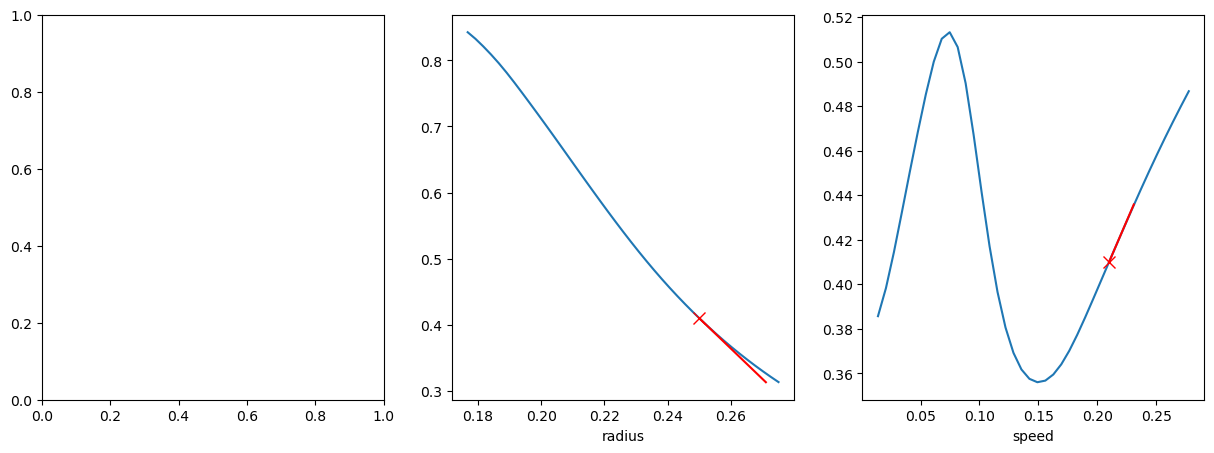

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
norm = la.norm(der_ref_D)
scale = 0.1/norm

if not bool_skip_2D_plots:
    axs[0].pcolormesh(vec_speed_2d, vec_radius_2d, util[1, :, :])
    axs[0].plot([vec_speed_2d[0], vec_speed_2d[-1]], [radius_test, radius_test], color="r", marker=None)
    axs[0].plot([speed_test, speed_test], [vec_radius_2d[0], vec_radius_2d[-1]], color="r", marker=None)
    axs[0].plot([speed_test, speed_test - 0.5 * scale * der_ref_D[1]], 
                [radius_test, radius_test - 0.5 * scale * der_ref_D[0]], 
                color = "w", marker = None)
    axs[0].set_xlabel("speed")
    axs[0].set_ylabel("radius")
    axs[0].set_xlim([np.min(vec_speed), np.max(vec_speed)])
    axs[0].set_ylim([np.min(vec_radius), np.max(vec_radius)])
    axs[0].set_title("D-OED")

axs[1].plot(vec_radius, util_test[1, 1, :])
axs[1].plot([radius_test], util_ref[1], marker="x", markersize=8, color="r")
axs[1].plot([radius_test, radius_test + scale], 
            [util_ref[1], util_ref[1]+scale*der_ref_D[0]], 
            marker="", markersize=8, color="r")
axs[1].set_xlabel("radius")

axs[2].plot(vec_speed, util_test[1, 0, :-1])
axs[2].plot([speed_test], util_ref[1], marker="x", markersize=8, color="r")
axs[2].plot([speed_test, speed_test + scale], 
            [util_ref[1], util_ref[1]+scale*der_ref_D[1]], 
            marker="", markersize=8, color="r")
axs[2].set_xlabel("speed")

Text(0.5, 0, 'speed')

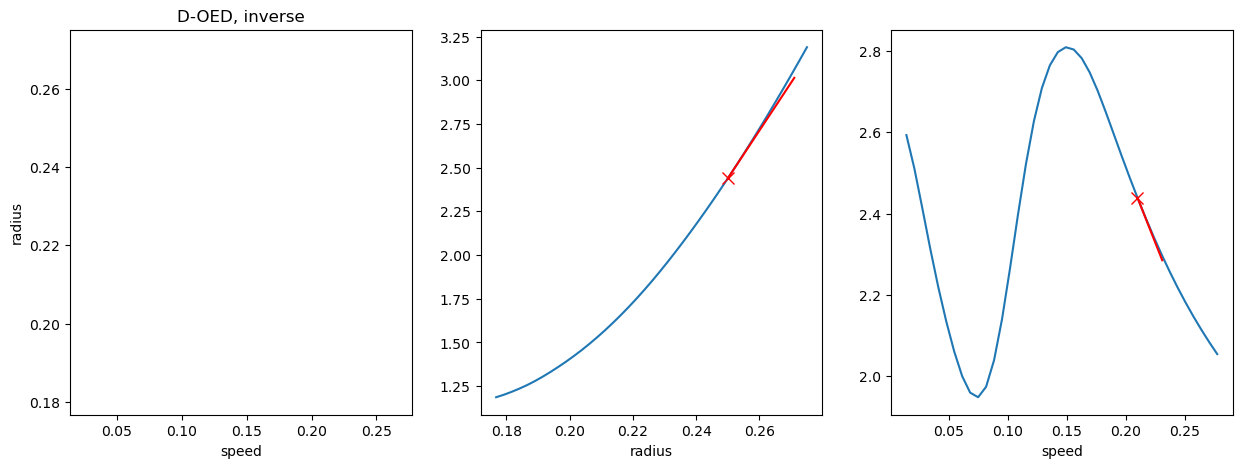

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
norm = la.norm(der_ref_D)
scale = 0.1/norm

if not bool_skip_2D_plots:
    axs[0].pcolormesh(vec_speed_2d, vec_radius_2d, 1/util[1, :, :])
    axs[0].plot([vec_speed_2d[0], vec_speed_2d[-1]], [radius_test, radius_test], color="r", marker=None)
    axs[0].plot([speed_test, speed_test], [vec_radius_2d[0], vec_radius_2d[-1]], color="r", marker=None)
    axs[0].plot([speed_test, speed_test + 0.2 * scale * der_ref_Dinv[1]], 
                [radius_test, radius_test + 0.2 * scale * der_ref_Dinv[0]], 
                color = "w", marker = None)
    # positive gradient direction because we want to maximize

axs[0].set_xlabel("speed")
axs[0].set_ylabel("radius")
axs[0].set_title("D-OED, inverse")
axs[0].set_xlim([np.min(vec_speed), np.max(vec_speed)])
axs[0].set_ylim([np.min(vec_radius), np.max(vec_radius)])

axs[1].plot(vec_radius, util_test[2, 1, :])
axs[1].plot([radius_test], util_ref[2], marker="x", markersize=8, color="r")
axs[1].plot([radius_test, radius_test + scale], 
            [util_ref[2], util_ref[2]+scale*der_ref_Dinv[0]], 
            marker="", markersize=8, color="r")
axs[1].set_xlabel("radius")

axs[2].plot(vec_speed, util_test[2, 0, :-1])
axs[2].plot([speed_test], util_ref[2], marker="x", markersize=8, color="r")
axs[2].plot([speed_test, speed_test + scale], 
            [util_ref[2], util_ref[2]+scale*der_ref_Dinv[1]], 
            marker="", markersize=8, color="r")
axs[2].set_xlabel("speed")

## The End.

In [23]:
runtime_notebook = time.time()-tStart_notebook
print("Runtime of this notebook: {} min".format(runtime_notebook / 60))

Runtime of this notebook: 6.224219103654225 min
